# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_validate

# Execute this cell to enable a nice display for your pipelines
from sklearn import set_config; set_config(display='diagram')
import math

## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [3]:
data = pd.read_csv('tv_movies_popularity.csv')
print(data.shape)
data.head()

(6864, 17)


,original_title,title,popularity,release_date,duration_min,description,budget,revenue,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,6.575393,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,12314651.0,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,8.248895,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,95149435.0,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,64.299990,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,13092000.0,en,Released,97,145,0,Drama,United States of America,0,True
3,Kahaani,Kahaani,3.174936,2012-03-09,122.0,A pregnant woman's search for her missing husb...,1200000,16000000.0,hi,Released,23,18,0,"Drama, Thriller",India,0,True
4,The Possession,The Possession,7.286477,2012-08-30,92.0,A young girl buys an antique box at a yard sal...,14000000,85446075.0,en,Released,0,6,0,"Horror, Thriller","Canada, United States of America",0,True


In [4]:
data.drop_duplicates(inplace=True)
data.shape #400 duplicate lines removed

(6464, 17)

In [5]:
for col in data.columns:
    print(f'{col} has {data[col].isnull().sum() / data.shape[0] *100}% missing values')

original_title has 0.0% missing values
title has 0.01547029702970297% missing values
popularity has 0.0% missing values
release_date has 0.0% missing values
duration_min has 0.0% missing values
description has 0.0% missing values
budget has 0.0% missing values
revenue has 59.51423267326733% missing values
original_language has 0.0% missing values
status has 0.0% missing values
number_of_awards_won has 0.0% missing values
number_of_nominations has 0.0% missing values
has_collection has 0.0% missing values
all_genres has 0.0% missing values
top_countries has 0.0% missing values
number_of_top_productions has 0.0% missing values
available_in_english has 0.0% missing values


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6464 entries, 0 to 6463
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   original_title             6464 non-null   object 
 1   title                      6463 non-null   object 
 2   popularity                 6464 non-null   float64
 3   release_date               6464 non-null   object 
 4   duration_min               6464 non-null   float64
 5   description                6464 non-null   object 
 6   budget                     6464 non-null   int64  
 7   revenue                    2617 non-null   float64
 8   original_language          6464 non-null   object 
 9   status                     6464 non-null   object 
 10  number_of_awards_won       6464 non-null   int64  
 11  number_of_nominations      6464 non-null   int64  
 12  has_collection             6464 non-null   int64  
 13  all_genres                 6464 non-null   objec

In [7]:
data.drop(columns='revenue', inplace=True)
data.shape #dropped 1 columns

(6464, 16)

In [8]:
data.isnull().sum(axis=1).value_counts()

0    6463
1       1
dtype: int64

In [9]:
data.dropna(axis=0, inplace=True)
data.shape #dropped 1 line

(6463, 16)

### 🧪 Run the following cell to save your results

In [10]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

In [11]:
# Distribution 

In [12]:
data.popularity.min(),data.popularity.max()

(0.096403, 547.488298)

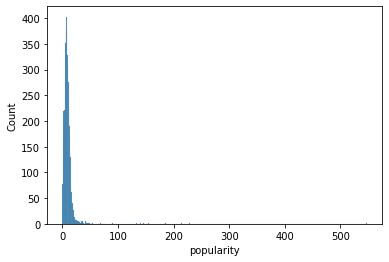

In [13]:
sns.histplot(data.popularity, kde=False);

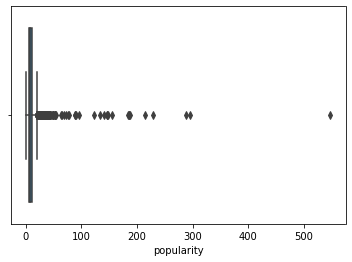

In [14]:
sns.boxplot(x=data.popularity);

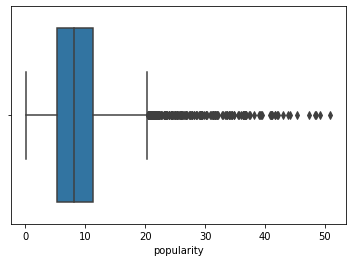

In [15]:
sns.boxplot(x=data.popularity.sort_values()[:-30]);

In [16]:
# Metric for regression that penalizes more on the low range ==> mean-squared-log-error
# https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error
# 'Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.'

scoring = 'neg_mean_squared_log_error'

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [17]:
X = data.copy().drop(columns='popularity')
y = data.popularity.copy()
print(X.columns, '\n', y.name)
X.shape, y.shape

Index(['original_title', 'title', 'release_date', 'duration_min',
       'description', 'budget', 'original_language', 'status',
       'number_of_awards_won', 'number_of_nominations', 'has_collection',
       'all_genres', 'top_countries', 'number_of_top_productions',
       'available_in_english'],
      dtype='object') 
 popularity


((6463, 15), (6463,))

### Basic pipeline

📝 **Check unique values per features**

In [18]:
for col in X.columns:
    print(f'{col} has {X[col].nunique()} unique values \n {X[col].unique()}  \n\n')

original_title has 6350 unique values 
 ['Hot Tub Time Machine 2' 'The Princess Diaries 2: Royal Engagement'
 'Whiplash' ... 'The Verdict' 'It Follows'
 'Vivre sa vie: film en douze tableaux']  


title has 6337 unique values 
 ['Hot Tub Time Machine 2' 'The Princess Diaries 2: Royal Engagement'
 'Whiplash' ... 'The Verdict' 'It Follows' 'Vivre Sa Vie']  


release_date has 4320 unique values 
 ['2015-02-20' '2004-08-06' '2014-10-10' ... '2006-01-30' '2015-06-23'
 '1962-09-20']  


duration_min has 152 unique values 
 [ 93. 113. 105. 122.  92. 100.  91. 119.  98. 118. 145.  97.  85. 111.
  96.  87. 130.  95. 116. 110.  84.  89. 112. 117. 106. 125.  94. 127.
 123. 126. 108.  88. 167. 102. 160. 107. 144. 124. 115. 133. 129. 104.
 103. 157. 109. 135. 147. 120. 121. 177. 189. 178.  86.  90.  79. 101.
  72.  99. 141. 136. 143. 132. 139. 114. 140.  83. 148. 137. 168. 156.
 154.  77.  76. 163. 155. 150. 149. 170.  80. 128. 131. 220. 181. 179.
  81.  82. 161. 134. 193. 158. 188. 212. 142. 146.

In this baseline, let's forget about the columns below that are difficult to process

In [19]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [20]:
X.columns

Index(['original_title', 'title', 'release_date', 'duration_min',
       'description', 'budget', 'original_language', 'status',
       'number_of_awards_won', 'number_of_nominations', 'has_collection',
       'all_genres', 'top_countries', 'number_of_top_productions',
       'available_in_english'],
      dtype='object')

In [21]:
X_baseline = X.drop(columns=['description', 'original_title', 'title', 'release_date'])
X_baseline.dtypes

duration_min                 float64
budget                         int64
original_language             object
status                        object
number_of_awards_won           int64
number_of_nominations          int64
has_collection                 int64
all_genres                    object
top_countries                 object
number_of_top_productions      int64
available_in_english            bool
dtype: object

In [22]:
numerical   = ['duration_min', 'budget', 'number_of_awards_won', 'number_of_nominations', \
               'number_of_top_productions']
categorical = ['original_language','status', 'has_collection', 'available_in_english', 'all_genres',\
               'available_in_english']

print(len(numerical + categorical))
assert len(numerical + categorical) == len(X_baseline.columns)

11


In [23]:
X_baseline

,duration_min,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,93.0,14000000,en,Released,0,2,1,Comedy,United States of America,3,True
1,113.0,40000000,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,105.0,3300000,en,Released,97,145,0,Drama,United States of America,0,True
3,122.0,1200000,hi,Released,23,18,0,"Drama, Thriller",India,0,True
4,92.0,14000000,en,Released,0,6,0,"Horror, Thriller","Canada, United States of America",0,True
...,...,...,...,...,...,...,...,...,...,...,...
6459,118.0,42000000,en,Released,0,2,0,Thriller,"France, United States of America",1,True
6460,95.0,19000000,en,Released,0,0,1,"Action, Adventure, Comedy, Thriller",United States of America,1,True
6461,129.0,16000000,en,Released,3,14,0,Drama,United States of America,1,True
6462,100.0,2000000,en,Released,25,43,0,"Horror, Thriller",United States of America,0,True


### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [24]:
num_transformer = RobustScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Paralellize "num_transformer" and "One hot encoder"
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, numerical),
    ('cat_transformer', cat_transformer, categorical)])

In [25]:
basic_preprocessing = make_pipeline(preprocessor)
print(type(basic_preprocessing))
basic_preprocessing

<class 'sklearn.pipeline.Pipeline'>


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  RobustScaler(),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'number_of_top_productions']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['original_language',
                                                   'status', 'has_collection',
                                                   'available_in_english',
                                                   'all_genres',
                                                   'available_in_english'])]))])

In [26]:
X_basic_preprocessing = basic_preprocessing.fit_transform(X)
X_basic_preprocessing

<6463x801 sparse matrix of type '<class 'numpy.float64'>'
	with 66852 stored elements in Compressed Sparse Row format>

In [27]:
X_basic_preprocessing.shape

(6463, 801)

**❓ How many features has been generated by the preprocessing? What do you think about this number?**

There are 801 features generated by the preprocessing. We might want to reduce it with PCA for instance, or reduce even further the features selected from the original dataframe

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [28]:
basic_pipeline = make_pipeline(
    basic_preprocessing,
    ElasticNet()
)
basic_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num_transformer',
                                                                   RobustScaler(),
                                                                   ['duration_min',
                                                                    'budget',
                                                                    'number_of_awards_won',
                                                                    'number_of_nominations',
                                                                    'number_of_top_productions']),
                                                                  ('cat_transformer',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['original_language',
                                                                    'status',
                                                                    'has_collection',
                                                                    'available_in_english',
                                                                    'all_genres',
                                                                    'available_in_english'])]))])),
                ('elasticnet', ElasticNet())])

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [29]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [30]:
basic_scores_all = cross_validate(basic_pipeline, X, y, cv=5,
                              scoring=(scoring),
                              return_train_score=True)
basic_scores_all

{'fit_time': array([0.09690213, 0.09496188, 0.09042192, 0.0896759 , 0.09129691]),
 'score_time': array([0.00943494, 0.00905108, 0.00971127, 0.00831079, 0.00804114]),
 'test_score': array([-0.30234149, -0.32444264, -0.31509574, -0.30351371, -0.33587408]),
 'train_score': array([-0.32138831, -0.31534091, -0.31510538, -0.31746235, -0.310437  ])}

In [31]:
basic_scores = basic_scores_all['test_score']
basic_scores

array([-0.30234149, -0.32444264, -0.31509574, -0.30351371, -0.33587408])

### 🧪 Save your results

Run the following cell to save your results

In [32]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Params:
        X: DataFrame
        y: Series
        
        Returns a DataFrame with 2 columns containing the time features as integers extracted from the release_date.
        """
        df = pd.concat((pd.to_datetime(X['release_date']).dt.month, pd.to_datetime(X['release_date']).dt.year), axis = 1)
        df.columns = ['month', 'year']
        return df

In [34]:
# Try your transformer and save your new features here
X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
X_time_features.head()

,month,year
0,2,2015
1,8,2004
2,10,2014
3,3,2012
4,8,2012


We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        #self.month_cos = np.cos(2 * math.pi / 12 * X[['month']])
        #self.month_sin = np.sin(2 * math.pi / 12 * X[['month']])
        #self.year = RobustScaler().fit_transform(X[['year']])
        
        return self

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
                
        month_cos = np.cos(2 * math.pi / 12 * X[['month']])
        month_sin = np.sin(2 * math.pi / 12 * X[['month']])
        year = pd.DataFrame(RobustScaler().fit_transform(TimeFeaturesExtractor().fit_transform(X)[['year']]))
        
        X_transformed = pd.concat([month_cos, month_sin, year], axis=1)
        X_transformed.columns = ['month_cos', 'month_sin', 'year']
        return  X_transformed

In [36]:
m = TimeFeaturesExtractor().fit_transform(X)[['month']]
c = np.cos(2 * math.pi / 12 * m)
s = np.sin(2 * math.pi / 12 * m)
year = pd.DataFrame(RobustScaler().fit_transform(TimeFeaturesExtractor().fit_transform(X)[['year']]))
d = pd.concat([c, s, year], axis=1)
d.columns = ['month_cos', 'month_sin', 'year']
d

,month_cos,month_sin,year
0,5.000000e-01,8.660254e-01,0.578947
1,-5.000000e-01,-8.660254e-01,0.000000
2,5.000000e-01,-8.660254e-01,0.526316
3,6.123234e-17,1.000000e+00,0.421053
4,-5.000000e-01,-8.660254e-01,0.421053
...,...,...,...
6459,-5.000000e-01,-8.660254e-01,0.000000
6460,-5.000000e-01,-8.660254e-01,-1.157895
6461,1.000000e+00,-2.449294e-16,0.578947
6462,5.000000e-01,8.660254e-01,-2.210526


In [37]:
# Try your transformer and save your new features here
X_time_cyclical = d.dropna()
#ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
X_time_cyclical.head() 

,month_cos,month_sin,year
0,5.000000e-01,0.866025,0.578947
1,-5.000000e-01,-0.866025,0.000000
2,5.000000e-01,-0.866025,0.526316
3,6.123234e-17,1.000000,0.421053
4,-5.000000e-01,-0.866025,0.421053


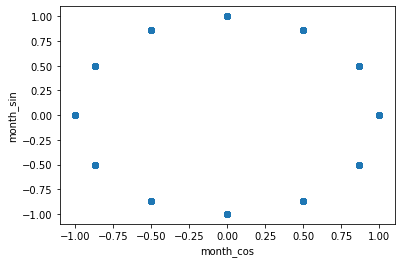

In [38]:
# Check that this form a circle with 12 points
plt.scatter(X_time_cyclical['month_cos'],
            X_time_cyclical['month_sin'])
plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [39]:
time_pipeline = make_pipeline(
    basic_preprocessing,
    TimeFeaturesExtractor(),
    CyclicalEncoder(),
    ElasticNet()
)
time_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num_transformer',
                                                                   RobustScaler(),
                                                                   ['duration_min',
                                                                    'budget',
                                                                    'number_of_awards_won',
                                                                    'number_of_nominations',
                                                                    'number_of_top_productions']),
                                                                  ('cat_transformer',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['original_language',
                                                                    'status',
                                                                    'has_collection',
                                                                    'available_in_english',
                                                                    'all_genres',
                                                                    'available_in_english'])]))])),
                ('timefeaturesextractor', TimeFeaturesExtractor()),
                ('cyclicalencoder', CyclicalEncoder()),
                ('elasticnet', ElasticNet())])

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [40]:
X[['all_genres', 'top_countries']].nunique()

all_genres       745
top_countries    320
dtype: int64

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [41]:
X[['all_genres', 'top_countries']].tail()

,all_genres,top_countries
6459,Thriller,"France, United States of America"
6460,"Action, Adventure, Comedy, Thriller",United States of America
6461,Drama,United States of America
6462,"Horror, Thriller",United States of America
6463,Drama,France


👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [42]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [43]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

(6463, 15)


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science Fiction,genre_Horror,genre_Family,country_United States of America,country_United Kingdom,country_France,country_Germany,country_Canada
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [44]:
ct = ColumnTransformer([
    ('num_transformer', num_transformer, numerical),
    ('cat_transformer', cat_transformer, ['original_language','status', 'has_collection', 'available_in_english']),
    ('time_transformer', TimeFeaturesExtractor(), ['release_date']),
    ('genre_country_transformer', CustomGenreAndCountryEncoder(), ['all_genres', 'top_countries'])
])


In [45]:
ct

ColumnTransformer(transformers=[('num_transformer', RobustScaler(),
                                 ['duration_min', 'budget',
                                  'number_of_awards_won',
                                  'number_of_nominations',
                                  'number_of_top_productions']),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['original_language', 'status',
                                  'has_collection', 'available_in_english']),
                                ('time_transformer', TimeFeaturesExtractor(),
                                 ['release_date']),
                                ('genre_country_transformer',
                                 CustomGenreAndCountryEncoder(),
                                 ['all_genres', 'top_countries'])])

In [46]:
final_pipeline = time_pipeline
final_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num_transformer',
                                                                   RobustScaler(),
                                                                   ['duration_min',
                                                                    'budget',
                                                                    'number_of_awards_won',
                                                                    'number_of_nominations',
                                                                    'number_of_top_productions']),
                                                                  ('cat_transformer',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['original_language',
                                                                    'status',
                                                                    'has_collection',
                                                                    'available_in_english',
                                                                    'all_genres',
                                                                    'available_in_english'])]))])),
                ('timefeaturesextractor', TimeFeaturesExtractor()),
                ('cyclicalencoder', CyclicalEncoder()),
                ('elasticnet', ElasticNet())])

📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

In [47]:
y

0        6.575393
1        8.248895
2       64.299990
3        3.174936
4        7.286477
          ...    
6459     9.970359
6460     6.046516
6461     9.596883
6462    20.359336
6463    11.305910
Name: popularity, Length: 6463, dtype: float64

In [48]:
final_scores_all = cross_validate(f_pipeline, X, y, cv=5,
                              scoring=(scoring),
                              return_train_score=True)
final_scores = final_scores_all['test_score']
final_scores

NameError: name 'f_pipeline' is not defined

### 🧪 Save your result

Run the following cell to save your results.

In [ ]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [ ]:
# YOUR CODE HERE

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [ ]:
# YOUR CODE HERE

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [ ]:
# YOUR CODE HERE

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

### 🧪 Save your results

Run the following cell to save your results.

In [ ]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**